# 列舉所有資產的riskiness r

In [244]:
import sympy
from pandas import Series,DataFrame
from scipy.optimize import fsolve
import math
import time
import pandas as pd
import numpy  as  np
import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

# 無風險利率
* 我們須扣除無風險利率，得到超額報酬率以計算Riskiness r
* 目前使用LIBOR [1個月利率](https://www.global-rates.com/interest-rates/libor/american-dollar/usd-libor-interest-rate-overnight.aspx)

In [245]:
rfrate = 2.45785 / 12 /100
rfrate

0.0020482083333333333

# 自定義 functions，用來計算風險指標
- get_riskiness_r(guess , arr_returns)
    - 計算Riskiness R
- get_all_risk_with_return_data(df)
    - 傳入多組ETF的月報酬序列資料，分別計算各組ETF的Riskiness R
- get_top5(df)
    - 依照R值排序，並傳回前5名的ETF
    
### 關於超額報酬的數量級:
* 將要帶入公式的數值調整到介在0-100間，目的是為了讓大部分的Riskiness r介在0-100間。

In [246]:
def f1(x,arr_returns):
    arr_returns = arr_returns
    return np.mean( np.exp(-1*arr_returns/x) ) - 1
def get_riskiness_r(guess , arr_returns):
    while (guess<10**(2)):
        risk2 = fsolve(f1,guess,arr_returns)  #引用函數f1
        #print('guess:',guess,'risk:',risk2,"value:",f1(risk2,arr_returns))
        if (risk2 != guess) and (f1(risk2,arr_returns)<0.1):
            break
        guess = guess*10
    return risk2

def get_all_risk_with_return_data(df):
    global rfrate
    
    etf_list = list(df.columns)
    etf_risk = []
    
    # 計算每支ETF的riskiness r
    for etf_name in etf_list:
        etf_returns = df[etf_name] - rfrate  
        guess = 10**(-5)
        risk_r = get_riskiness_r(guess,etf_returns)
        etf_risk.append([etf_name,risk_r])
        
    df = pd.DataFrame(etf_risk,columns=['Name','Riskiness R'])
    return df

def get_top5(df):
    df_sorted = df.sort_values(by=['Riskiness R'])
    df_top5 = df_sorted[:5]
    return df_top5

# 自定義 functions，用來計算最佳配置的權重值


In [251]:
def risk(x):
    guess  = 10**(-5)
    while (guess<1000):
        risk2 = fsolve(f1,guess,x)  #引用函數f1
        if risk2[0] != guess:
            break
        guess = guess*10
    return risk2[0]
    #return np.std(x)

def sumrisk(weight,all_return):
    w = weight
    a = all_return
    v = 0
    for i in range(len(w)):
        v = v + w[i]*risk(w[i]*(all_return.iloc[:,i]))
    return v

def penalty(w):
    if min(w)<0 or max(w)>1:
        return 100000
    else:
        return 0

def portretmean(weight,all_return):
    w = weight
    a = all_return
    return np.mean(np.dot(np.array(all_return),np.array(weight)))    

def bestweight(w,all_return):
    r = []
    r.append(penalty(w)+np.abs(sum(w)-1)*1000)
    for i in range(len(w)-1):
        v =  np.abs( risk(w[i]*(all_return.iloc[:,i]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i])-rfrate)/(portretmean(w,all_return)-rfrate) ) \
            + np.abs( risk(w[i+1]*(all_return.iloc[:,i+1]))/ sumrisk(w,all_return)  \
            - (np.mean(all_return.iloc[:,i+1])-rfrate)/(portretmean(w,all_return)-rfrate))
        r.append(v) 
    print('權重:',w,'誤差值:',v+penalty(w)+np.abs(sum(w)-1))
    return r

def fourdrop(x):
    a = []
    for i in range(len(x)):
        a.append(round(sum(x[i]),3))
    return a

# 完整的處理流程

依序產生以下檔案

- 每月資料夾下有4個檔案
    - all_group_return.csv：用來存所有群組的月報酬(該月報酬即為該群前5名ETF的月報酬之平均值)
    - all_group_risk.csv：用來存每個群組的Riskiness R(該Riskiness R是以該群月報酬去計算)
    - top5_group_list.csv：用來存所有群組中Riskiness R最小的前5名
    - top5_group_weight.csv：用來存前5名群組的最佳配置權重
    
- 每群資料夾下也有4個檔案
    - all_etf_return.csv：用來存該群中所有ETF的月報酬資料
    - all_etf_risk.csv：用來存該群中每支ETF以月報酬計算出來的Riskiness R
    - top5_etf_list.csv：用來存該群中前5名的ETF(以 Riskiness R 排序)
    - top5_etf_return.csv：用來存該群中前5名的ETF的月報酬取之平均值

In [252]:
def get_total_months(data_path):
    subdir = os.listdir(data_path)[0] #取第一個group的csv檔
    file_path = data_path + subdir + '/' + subdir + '_return.csv'
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        total_rows = df.shape[0]
        return total_rows

In [253]:
return_data_path = '../2014to2018RE_data/'
risk_data_path = '../2017to2019Risk_data/'

# 以程式取得資料總筆數
total_data = get_total_months(return_data_path)
print('共有',total_data,'個月的資料')

# 指定用來計算指標的資料個數
window_size = 36
print('取',window_size,'個月的資料計算風險指標')

rolling_times = total_data - window_size
print('共滾動',rolling_times,'次')

共有 61 個月的資料
取 36 個月的資料計算風險指標
共滾動 25 次


In [254]:
for i in range(rolling_times):
    print('=== Rolling #',i+1,'===')
    
    #第一層目錄
    first_month = '2017-01-01'
    first_date = datetime.strptime(first_month,'%Y-%m-%d')
    the_date = first_date + relativedelta(months=i)
    date_string = the_date.strftime('%Y-%m-%d')
    risk_dir_path = os.path.join(risk_data_path,date_string)
    if not os.path.exists(risk_dir_path):
        os.makedirs(risk_dir_path)
        print('新增資料夾',risk_dir_path)
        
    #第二層目錄
    risk_dir_path_2nd = os.path.join(risk_dir_path,'all_groups/')
    if not os.path.exists(risk_dir_path_2nd):
        os.makedirs(risk_dir_path_2nd)
        print('新增資料夾',risk_dir_path_2nd)

    allgroup_top5_return = DataFrame()
    allgroup_top5_dict = dict()
    
    for subdir in os.listdir(return_data_path):
        #第三層目錄(group name)
        risk_dir_path_3rd = os.path.join(risk_dir_path_2nd,subdir)
        if not os.path.exists(risk_dir_path_3rd):
            os.makedirs(risk_dir_path_3rd)
            print('新增資料夾',risk_dir_path_3rd)
        
        subdir_path = os.path.join(return_data_path,subdir)
        if os.path.exists(subdir_path) and os.path.isdir(subdir_path):
            file = subdir + '_return.csv'
            file_path = os.path.join(subdir_path, file)
            if os.path.isfile(file_path):
                df = pd.read_csv(file_path)
                df_return = df.iloc[i:i+window_size,2:]
                print(df_return.shape)
                df_return = df_return.dropna(axis=1)
                print(df_return.shape)
                
                #第三層目錄下的檔案
                # 0. all_etf_return.csv
                csv_file = "all_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_return.to_csv(save_path,index=False)
                
                # 1. all_etf_risk.csv
                df_etf_risk = get_all_risk_with_return_data(df_return)
                csv_file = "all_etf_risk.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_etf_risk.to_csv(save_path,index=False)
                
                # 2. top5_etf_list.csv
                df_top5_etf = get_top5(df_etf_risk)
                csv_file = "top5_etf_list.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                df_top5_etf.to_csv(save_path,index=False)
                
                # 3. top5_etf_return.csv
                top5_etf = df_top5_etf['Name']
                top5_return_average = df_return[top5_etf].mean(axis=1)
                allgroup_top5_return[subdir] = top5_return_average
                
                csv_file = "top5_etf_return.csv"
                save_path = os.path.join(risk_dir_path_3rd,csv_file)
                top5_return_average.to_csv(save_path,index=False)
                
                # 4. the_group_risk.csv
                # 改在第二層
                
                #[ top5_etf,allgroup_top5_return[subdir] ] = get_top5_etf(df)
                print('Group:',subdir)
                print('Top5:',top5_etf)
                print('================')
                #allgroup_top5_dict[subdir] = top5_etf
                
    #第二層
    # 4. all_group_return
    csv_file = "all_group_return.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    allgroup_top5_return.to_csv(save_path,index=False)
    
    # 5. all_group_risk
    df_group_risk = get_all_risk_with_return_data(allgroup_top5_return)
    csv_file = "all_group_risk.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_group_risk.to_csv(save_path,index=False)
    
    # 6. top5_group_list
    df_top5_group = get_top5(df_group_risk)
    csv_file = "top5_group_list.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_top5_group.to_csv(save_path,index=False)
    
    # 7. top_group_weight
    top5_group = df_top5_group['Name']    
    top5_group_return = allgroup_top5_return[top5_group]
    n = top5_group_return.shape[1]
    weight = [1/n]*n
    top5_group_best_weight = fsolve(bestweight,weight,top5_group_return)
    print(top5_group_best_weight)
    
    weight_list = []
    for i,group_name in enumerate(top5_group):
        group_weight = top5_group_best_weight[i]
        weight_list.append([group_name,group_weight])
    
    df_best_weight = pd.DataFrame(weight_list,columns=['Name','Weight'])
    print(df_best_weight)
    
    csv_file = "top5_group_weight.csv"
    save_path = os.path.join(risk_dir_path,csv_file)
    df_best_weight.to_csv(save_path,index=False)


=== Rolling # 1 ===
(36, 21)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
10     FPA
7     DBAP
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 63     UCO
5     BOIL
28     DTO
54     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
15     RXI
3     FDIS
12     RCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 30    IDOG
5      DOO
38     VPL
14     EWJ
20     FDT
Name: Name, dtype: object
(36, 80)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 26    IDOG
62     VSS
63      VT
59    URTH
39     KXI
Name: Name, dtype: object
(36, 58)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 8      EFZ
6      DOO
27     PIZ
0     ACIM
9      EXI
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
6      FLM
3      EFO
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    YINN
41    INDL
34     FXP
39    INCO
52    SMIN
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 18     EEV
11     EDZ
9      EDC
0     ADRE
30     PXH
Name: Name, dtype: object
(36, 60)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 18    KBWP
21     KIE
34     VQT
32     UYG
6     FINZ
Name: Name, dtype: object
(36, 40)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
15    GDXJ
13    FONE
19     IFV
9     FIEG
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
4      DZZ
7      IAU
3      DGZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 21    _PRN
5      FXR
6      IEV
0      CGW
18     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYND
8    HYZD
3    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
10    GDXJ
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 0     ITM
3     PVI
4     PZA
10    TFI
2     MUB
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
0    BSCJ
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    NEAR
19    ULST
13    MINT
20    XMPT
3      BLV
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741998023297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741998023297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741998023297
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741531755384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043742051271325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374196727471
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741705078775
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374184524064


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 21.39358373   0.27033075  23.10449242 -26.9313639  -16.8367829 ] 誤差值: 100002.26489174984
權重: [ 1.9467423   0.39998855 -3.01738233 -5.5639013   7.22586009] 誤差值: 100001.51087276223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741531755384
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043742051271325
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374196727471
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.0043741705078775
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.004374184524064
權重: [ 21.39358373   0.27033075  23.10449242 -26.9313639  -16.8367829 ] 誤差值: 100002.26489174984
權重: [ 1.9467423   0.39998855 -3.01738233 -5.5639013   7.22586009] 誤差值: 100001.51087276223
權重: [ 0.46855495  0.39999772 -0.13125494  0.24653193  0.01402857] 誤差值: 100001.50432590887
權重: [0.2530655  0.37198181 0.32798593 0.30981847 0.26174867] 誤差值: 2.1422111737746956
權重: [0.22068971 0.28085957 0.26847431 0.2660807  0.21186149] 誤差值: 2.390664693486308
權重: [0.20732327 0.23674181 0.23524634 0.23721996 0.19690282] 誤差值: 2.653839134659976
權重: [0.20221029 0.2162157  0.21762029 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
10     FPA
9     EEMA
2     ADRA
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 63     UCO
5     BOIL
28     DTO
54     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 31    IDOG
6      DOO
39     VPL
15     EWJ
21     FDT
Name: Name, dtype: object
(36, 80)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 26    IDOG
62     VSS
63      VT
59    URTH
39     KXI
Name: Name, dtype: object
(36, 58)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
7      DOO
28     PIZ
0     ACIM
10     EXI
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
11     IPO
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    YINN
41    INDL
34     FXP
52    SMIN
39    INCO
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 30     PXH
0     ADRE
32    SCHE
26    FNDE
34    TLTE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
10     FAN
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21     KIE
34     VQT
18    KBWP
32     UYG
6     FINZ
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
16    GDXJ
20     IFV
10    FIEG
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
7      IAU
9      UBG
8     SGOL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
8     IHF
21    XHE
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 21    _PRN
5      FXR
6      IEV
0      CGW
18     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYND
8    HYZD
3    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 10    HOLD
16    NEAR
21    ULST
15    MINT
22    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379089113005669
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379089113005669
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379089113005669
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088984715095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.337908924654089
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.337908915243708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088905255412
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088962634804


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 1.19917257  0.26746948 -0.50079387 -0.70489738  0.7390492 ] 誤差值: 100001.80864030887
權重: [0.29579236 0.58343653 0.555291   0.26488547 0.48789592] 誤差值: 2.0869958950955754
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088984715095
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.337908924654089
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.337908915243708
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088905255412
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.3379088962634804
權重: [ 1.19917257  0.26746948 -0.50079387 -0.70489738  0.7390492 ] 誤差值: 100001.80864030887
權重: [0.29579236 0.58343653 0.555291   0.26488547 0.48789592] 誤差值: 2.0869958950955754
權重: [0.28561388 0.38369622 0.37597916 0.27818502 0.31926866] 誤差值: 1.396125937407874
權重: [0.2338615  0.29244605 0.29114487 0.23683923 0.26113798] 誤差值: 1.3039168625370179
權重: [0.21179613 0.24648794 0.24696446 0.21662622 0.23148752] 誤差值: 1.314254892567276
權重: [0.2038083  0.22325614 0.22400713 0.20777317 0.21585389] 誤差值: 1.329725472543283
權重: [0.20122414 0.21158289 0.21221488 0.20391914 0.20778722] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
10     FPA
9     EEMA
2     ADRA
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 63     UCO
5     BOIL
28     DTO
54     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 32    IDOG
6      DOO
40     VPL
15     EWJ
21     FDT
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
63     VSS
64      VT
25    HEFA
60    URTH
Name: Name, dtype: object
(36, 58)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
7      DOO
21    IPKW
29     PIZ
0     ACIM
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
7     FTAG
0     CARZ
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 62)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 60    YINN
41    INDL
34     FXP
52    SMIN
39    INCO
Name: Name, dtype: object
(36, 44)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 30     PXH
3      BKF
33    SPEM
32    SCHE
0     ADRE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
10     FAN
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21     KIE
34     VQT
18    KBWP
32     UYG
6     FINZ
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
16    GDXJ
20     IFV
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
4      DZZ
3      DGZ
6      GLL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 21    _PRN
5      FXR
6      IEV
0      CGW
18     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYND
8    HYZD
3    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 10    HOLD
16    NEAR
21    ULST
15    MINT
22    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214784059233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214784059233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214784059233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214536462456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214809584865
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214921963971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214521446541
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214604597638


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 10.96328273   3.39299753  -3.98234777 -16.06470093   6.69076844] 誤差值: 100001.15448476691
權重: [0.13341955 0.45088533 0.52913681 0.44365199 0.36799009] 誤差值: 3.4861232034493117
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214536462456
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214809584865
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214921963971
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214521446541
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8033214604597638
權重: [ 10.96328273   3.39299753  -3.98234777 -16.06470093   6.69076844] 誤差值: 100001.15448476691
權重: [0.13341955 0.45088533 0.52913681 0.44365199 0.36799009] 誤差值: 3.4861232034493117
權重: [0.1056325  0.20978413 0.27073566 0.36495651 0.35684754] 誤差值: 1.3787587987879872
權重: [0.15011271 0.1988605  0.24443087 0.30002207 0.24455393] 誤差值: 1.4411480821942138
權重: [0.17332236 0.20341977 0.22494176 0.25253239 0.20286784] 誤差值: 1.6890909834630903
權重: [0.18589381 0.2012617  0.21194264 0.22580393 0.19560775] 誤差值: 1.7797120451487256
權重: [0.19261838 0.19986589 0.20530024 0.21271174 0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
10     FPA
7     DBAP
9     EEMA
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 63     UCO
5     BOIL
28     DTO
54     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
3    OLO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 32    IDOG
6      DOO
40     VPL
15     EWJ
21     FDT
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
63     VSS
64      VT
25    HEFA
60    URTH
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
34    TOLZ
7      DOO
21    IPKW
29     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
7     FTAG
5     FDTS
Name: Name, dtype: object
(36, 78)
(36, 63)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 61    YINN
41    INDL
34     FXP
53    SMIN
39    INCO
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
31     PXH
0     ADRE
35    TLTE
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
10     FAN
Name: Name, dtype: object
(36, 42)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 21     KIE
34     VQT
18    KBWP
32     UYG
6     FINZ
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
16    GDXJ
20     IFV
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
4      DZZ
7      IAU
0      DGL
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
18    RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    _PRN
6      FXR
7      IEV
1      CGW
19     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYND
8    HYZD
3    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 10    HOLD
16    NEAR
21    ULST
15    MINT
22    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392346793463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392346793463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392346793463
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392246328762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392306946225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392301197068
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392171504722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392417449995


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-3.45578698 -1.89197195  0.77099995  3.63393833  1.94282065] 誤差值: 100001.26953154047
權重: [0.31199201 0.52210102 0.54436959 0.21155407 0.48335098] 誤差值: 1.3731277273012998
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392246328762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392306946225
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392301197068
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392171504722
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8182392417449995
權重: [-3.45578698 -1.89197195  0.77099995  3.63393833  1.94282065] 誤差值: 100001.26953154047
權重: [0.31199201 0.52210102 0.54436959 0.21155407 0.48335098] 誤差值: 1.3731277273012998
權重: [0.3282271  0.31213635 0.37716143 0.20421226 0.33565966] 誤差值: 1.6826542271094225
權重: [0.26556156 0.26982557 0.28249025 0.19117805 0.26041217] 誤差值: 1.6829346203349207
權重: [0.23211642 0.2411689  0.23769267 0.18994558 0.22604477] 誤差值: 1.7406953953645088
權重: [0.21618776 0.22231652 0.21716046 0.19246973 0.21097104] 誤差值: 1.7819003746461781
權重: [0.20852617 0.21140774 0.20783789 0.19520633 0.20454523]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 17    VXUS
3      AIA
9     EEMA
10     FPA
0     AAXJ
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 63     UCO
5     BOIL
28     DTO
54     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
41     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
63     VSS
64      VT
25    HEFA
60    URTH
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
34    TOLZ
7      DOO
21    IPKW
29     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
7     FTAG
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 64)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 62    YINN
42    INDL
35     FXP
40    INCO
54    SMIN
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
34    SPEM
35    TLTE
31     PXH
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
41     PZD
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
35     VQT
19    KBWP
33     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
29    SOCL
16    GDXJ
20     IFV
Name: Name, dtype: object
(36, 12)
(36, 11)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10    UGLD
9      UBG
7      IAU
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    _PRN
6      FXR
7      IEV
1      CGW
19     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYND
8    HYZD
3    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
17    NEAR
22    ULST
16    MINT
23    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219851477046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219851477046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219851477046
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219716240766
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.169221986823856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219948220917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219531092114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219656004204


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.94112035  0.31049496 -0.5344826  -0.45555599  0.73842327] 誤差值: 100003.28352224678
權重: [0.36189503 0.51484766 0.5806099  0.22310581 0.42253213] 誤差值: 2.6813014840766045
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219716240766
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.169221986823856
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219948220917
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219531092114
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1692219656004204
權重: [ 0.94112035  0.31049496 -0.5344826  -0.45555599  0.73842327] 誤差值: 100003.28352224678
權重: [0.36189503 0.51484766 0.5806099  0.22310581 0.42253213] 誤差值: 2.6813014840766045
權重: [0.26147382 0.32237726 0.37662512 0.25753785 0.36370819] 誤差值: 1.7446847838105584
權重: [0.23183356 0.26752514 0.29302922 0.22557701 0.27165332] 誤差值: 1.8623945141764588
權重: [0.21628069 0.23651763 0.24884034 0.2103642  0.23020949] 誤差值: 2.015614876984083
權重: [0.20796301 0.21891652 0.22528928 0.20434554 0.21308947] 誤差值: 2.1028623543049467
權重: [0.20375179 0.2095053  0.21294817 0.20208671 0.20602639] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 12    IHDG
18    VXUS
3      AIA
10     FPA
9     EEMA
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
41     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 68)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
64     VSS
65      VT
25    HEFA
61    URTH
Name: Name, dtype: object
(36, 58)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
34    TOLZ
7      DOO
21    IPKW
29     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
7     FTAG
Name: Name, dtype: object
(36, 78)
(36, 65)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 63    YINN
43    INDL
36     FXP
41    INCO
55    SMIN
Name: Name, dtype: object
(36, 44)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 0     ADRE
3      BKF
35    TLTE
34    SPEM
2     BICK
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
35     VQT
19    KBWP
33     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
29    SOCL
14    FONE
16    GDXJ
20     IFV
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
2      DGP
9     SGOL
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    _PRN
6      FXR
7      IEV
1      CGW
19     VIS
Name: Name, dtype: object
(36, 22)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
10    SPLB
12    VCLT
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
17    NEAR
22    ULST
16    MINT
23    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357593571989
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357583050607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575947099267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223576008916876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575620687214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575728473616


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.62455394  0.28473969 -0.38785905 -0.16892751  0.64749293] 誤差值: 100009.016257097
權重: [0.36036878 0.45465483 0.51273839 0.16787466 0.36717224] 誤差值: 2.41333344901273
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.122357583050607
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575947099267
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223576008916876
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575620687214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1223575728473616
權重: [ 0.62455394  0.28473969 -0.38785905 -0.16892751  0.64749293] 誤差值: 100009.016257097
權重: [0.36036878 0.45465483 0.51273839 0.16787466 0.36717224] 誤差值: 2.41333344901273
權重: [0.29380309 0.29188069 0.35527528 0.23451917 0.3086    ] 誤差值: 1.7376529769658253
權重: [0.24370658 0.25257238 0.28024847 0.20981479 0.24872485] 誤差值: 1.8897167939812842
權重: [0.22002045 0.22920777 0.24098184 0.20123643 0.22147475] 誤差值: 2.02600648296409
權重: [0.20931759 0.21533537 0.22077286 0.19962485 0.20976671] 誤差值: 2.086388716209054
權重: [0.20444544 0.20775859 0.21052595 0.19968139 0.20462642] 誤差值: 2.1074

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
20    VXUS
3      AIA
10    EEMA
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
11    PSCD
15     RXI
3     FDIS
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
43     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
66     VSS
67      VT
25    HEFA
63    URTH
Name: Name, dtype: object
(36, 58)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
35    TOLZ
7      DOO
22    IPKW
30     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
7     FTAG
Name: Name, dtype: object
(36, 78)
(36, 66)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 64    YINN
44    INDL
37     FXP
42    INCO
56    SMIN
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
0     ADRE
19     EEV
3      BKF
12     EDZ
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
35     VQT
19    KBWP
33     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
30    SOCL
16    GDXJ
20     IFV
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
4      DZZ
6      GLL
3      DGZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
8     IHF
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    _PRN
6      FXR
7      IEV
1      CGW
19     VIS
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
11    SPLB
13    VCLT
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
10    GDXJ
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
4      PZA
11     TFI
3      PVI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 7      ICF
19     RWR
28     WPS
4      FRI
21    SCHH
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
18    NEAR
23    ULST
17    MINT
24    XMPT
Name: Name, dtype: object
(36, 41)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 27     TUZ
17     SHY
36    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
12    VPU
13    XLU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449145089340785
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449145089340785
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449145089340785
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.244914493356193
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.24491450929872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.244914517811166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449144756861905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449144867966755


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 1.00343955  0.33805389 -0.58735584 -0.64176366  0.88762605] 誤差值: 100003.33781816026
權重: [0.35261967 0.54818074 0.62834069 0.20454164 0.40683515] 誤差值: 2.5905077636346037
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.244914493356193
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.24491450929872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.244914517811166
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449144756861905
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.2449144867966755
權重: [ 1.00343955  0.33805389 -0.58735584 -0.64176366  0.88762605] 誤差值: 100003.33781816026
權重: [0.35261967 0.54818074 0.62834069 0.20454164 0.40683515] 誤差值: 2.5905077636346037
權重: [0.26396823 0.34114014 0.41031442 0.24414404 0.35001715] 誤差值: 1.8463382956160135
權重: [0.23151523 0.27580667 0.30809374 0.22100864 0.26564526] 誤差值: 1.9390659108234085
權重: [0.21543459 0.24038121 0.25556646 0.20911152 0.22746306] 誤差值: 2.083575272263614
權重: [0.20729007 0.22081384 0.228461   0.20399918 0.21166449] 誤差值: 2.173367150964792
權重: [0.20332959 0.21043655 0.2145171  0.20196997 0.20524186] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
20    VXUS
3      AIA
10    EEMA
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13     XLP
2     FSTA
12     VDC
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
43     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 27    IDOG
66     VSS
67      VT
25    HEFA
63    URTH
Name: Name, dtype: object
(36, 58)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 9      EFZ
35    TOLZ
7      DOO
22    IPKW
30     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
11     IPO
5     FDTS
6      FLM
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65    YINN
45    INDL
38     FXP
43    INCO
12    CNXT
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
3      BKF
7      DGS
36    TLTE
4     DBEM
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
36     VQT
19    KBWP
34     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
14    FONE
30    SOCL
16    GDXJ
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
4      DZZ
2      DGP
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
18    RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
11    SPLB
13    VCLT
Name: Name, dtype: object
(36, 20)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
17     ITB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 15    REET
7      ICF
20     RWR
29     WPS
4      FRI
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
18    NEAR
23    ULST
17    MINT
24    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3     GII
13    XLU
12    VPU
5     IGF
11    UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864380058927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864380058927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864380058927
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864336472637
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864379114802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086444900583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086412302351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086417776812


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 1.48148203 -1.55074994  1.0144067   2.61609911 -2.56123789] 誤差值: 100001.45624267026
權重: [0.5588526  0.55628152 0.64543026 0.20462522 0.36692681] 誤差值: 3.093884484853805
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864336472637
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0300864379114802
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086444900583
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086412302351
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.030086417776812
權重: [ 1.48148203 -1.55074994  1.0144067   2.61609911 -2.56123789] 誤差值: 100001.45624267026
權重: [0.5588526  0.55628152 0.64543026 0.20462522 0.36692681] 誤差值: 3.093884484853805
權重: [0.35837865 0.29680727 0.42341189 0.22445188 0.38850361] 誤差值: 1.4571391045427056
權重: [0.24040791 0.25387424 0.33055991 0.20480651 0.29230845] 誤差值: 1.825653602532531
權重: [0.22285651 0.24049413 0.2590061  0.19687597 0.24333152] 誤差值: 1.9152872931331302
權重: [0.21474514 0.22429884 0.22463761 0.19480784 0.22100002] 誤差值: 1.9772122303891118
權重: [0.20743996 0.213125   0.21087818 0.19589641 0.21038809] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
7      MOM
12     SIZ
1     CHEP
13    WTMF
Name: Name, dtype: object
(36, 27)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 13    IHDG
20    VXUS
3      AIA
10    EEMA
8     DBAP
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
9      FXA
15     FXS
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
43     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 28    IDOG
67     VSS
68      VT
25    HEFA
64    URTH
Name: Name, dtype: object
(36, 58)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 10     EFZ
36    TOLZ
7      DOO
23    IPKW
31     PIZ
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 1     CROP
13     PEX
5     FDTS
11     IPO
3      EFO
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65    YINN
45    INDL
38     FXP
12    CNXT
43    INCO
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
25     FEM
3      BKF
7      DGS
35    SPEM
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
36     VQT
19    KBWP
34     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
30    SOCL
14    FONE
16    GDXJ
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
7      IAU
2      DGP
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24    XPH
1     BIB
9     IHI
21    XHE
18    RYH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
11    SPLB
13    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 4     DUST
20    JNUG
32    RING
2     CROP
17     ITB
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 15    REET
7      ICF
20     RWR
29     WPS
4      FRI
Name: Name, dtype: object
(36, 16)
(36, 6)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4    IBDC
2    IBCD
3    IBCE
1    BSCM
5    IBDD
Name: Name, dtype: object
(36, 47)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 5      IGM
28    TDIV
9      IXN
2     FTEC
32     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
18    NEAR
23    ULST
17    MINT
25    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
14     XLU
12     VPU
5      IGF
13    WBIC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128887049721
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128887049721
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128887049721
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128847779232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128889502764
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128927150426
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.760412863522081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.760412868431783


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 1.16177594 -1.22917136  0.91494345  2.0340172  -1.88156523] 誤差值: 100001.74718618001
權重: [0.93685353 0.9141756  1.16395695 0.03244452 0.36297219] 誤差值: 100003.02045642202
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128847779232
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128889502764
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7604128927150426
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.760412863522081
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.760412868431783
權重: [ 1.16177594 -1.22917136  0.91494345  2.0340172  -1.88156523] 誤差值: 100001.74718618001
權重: [0.93685353 0.9141756  1.16395695 0.03244452 0.36297219] 誤差值: 100003.02045642202
權重: [ 0.25977043 -0.21588518  0.19516514  0.60584342 -0.20978396] 誤差值: 100007.67278057756
權重: [ 0.0478487  -0.06104941  0.06584828  0.30171839  0.28753359] 誤差值: 100001.6166235129
權重: [0.32656643 0.18828631 0.30882954 0.26140028 0.20741663] 誤差值: 1.5177433096039277
權重: [0.25901485 0.19926039 0.25630664 0.23575584 0.19509717] 誤差值: 1.591398523800809
權重: [0.22784705 0.20064938 0.22881782 0.21798979 0.192

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 3     FLAG
8      MOM
13     SIZ
1     CHEP
12     RLY
Name: Name, dtype: object
(36, 27)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
21    VXUS
3      AIA
10    EEMA
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
43     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 28    IDOG
67     VSS
68      VT
25    HEFA
64    URTH
Name: Name, dtype: object
(36, 58)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 17    FYLD
11     EFZ
37    TOLZ
8      DOO
24    IPKW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
1     CROP
13     PEX
5     FDTS
11     IPO
Name: Name, dtype: object
(36, 78)
(36, 67)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 65    YINN
45    INDL
38     FXP
2      AIA
12    CNXT
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 3      BKF
26    FEMS
25     FEM
4     DBEM
7      DGS
Name: Name, dtype: object
(36, 60)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 32     NLR
16    GASL
9      ERY
11     FCG
19    GRID
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
36     VQT
19    KBWP
34     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
31    SOCL
14    FONE
16    GDXJ
25     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10     UBG
11    UGLD
2      DGP
7      IAU
Name: Name, dtype: object
(36, 34)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 24     XPH
1      BIB
9      IHI
21     XHE
15    PSCH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
12    SPLB
14    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 6      IGM
29    TDIV
10     IXN
3     FTEC
33     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    HOLD
18    NEAR
23    ULST
17    MINT
25    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
14     XLU
12     VPU
5      IGF
13    WBIC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197563210112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197563210112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197563210112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197533866604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197554207467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197547402934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197455997052
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.919919770941406


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.02051619 -0.22485504  0.21194846  0.68508264  0.30730775] 誤差值: 100001.80866711054
權重: [0.22338122 0.35604722 0.41351579 0.29167981 0.38981514] 誤差值: 1.3313062858331965
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197533866604
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197554207467
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197547402934
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.9199197455997052
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.919919770941406
權重: [ 0.02051619 -0.22485504  0.21194846  0.68508264  0.30730775] 誤差值: 100001.80866711054
權重: [0.22338122 0.35604722 0.41351579 0.29167981 0.38981514] 誤差值: 1.3313062858331965
權重: [0.21818223 0.28111941 0.30385563 0.24810069 0.2933794 ] 誤差值: 1.1091291324068608
權重: [0.21034473 0.24146323 0.25146444 0.22376417 0.24629303] 誤差值: 1.0110925632722163
權重: [0.20486092 0.22094317 0.22595899 0.211132   0.22314327] 誤差值: 0.9675352476293886
權重: [0.20219501 0.21056043 0.21311485 0.20514888 0.21157846] 誤差值: 0.9454023159815005
權重: [0.20103292 0.20533978 0.20659317 0.20240435 0.20577901] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
9      MOM
14     SIZ
2     CHEP
13     RLY
Name: Name, dtype: object
(36, 27)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 14    IHDG
22    VXUS
3      AIA
10    EEMA
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 64     UCO
5     BOIL
28     DTO
55     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
(36, 61)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
43     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 28    IDOG
67     VSS
68      VT
25    HEFA
64    URTH
Name: Name, dtype: object
(36, 58)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 18    FYLD
12     EFZ
38    TOLZ
9      DOO
25    IPKW
Name: Name, dtype: object
(36, 28)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
1     CROP
5     FDTS
13     PEX
11     IPO
Name: Name, dtype: object
(36, 78)
(36, 68)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
66    YINN
46    INDL
39     FXP
2      AIA
Name: Name, dtype: object
(36, 44)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 26    FEMS
4     DBEM
7      DGS
3      BKF
29    IEMG
Name: Name, dtype: object
(36, 60)
(36, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 33     NLR
17    GASL
10     ERY
42     PZD
12     FCG
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
36     VQT
19    KBWP
34     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
31    SOCL
14    FONE
9      FAN
25     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
9     SGOL
7      IAU
10     UBG
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 25     XPH
2      BIB
10     IHI
22     XHE
16    PSCH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
12    SPLB
14    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 7      IGM
30    TDIV
11     IXN
4     FTEC
34     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    NEAR
20    MINT
26    ULST
29    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
14     XLU
12     VPU
5      IGF
13    WBIC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 0    SVXY
7     ZIV
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827126182233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827126182233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827126182233
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827074187847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.749382706357481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827067005847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827286518935
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493826960390677


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.13445455  0.17499384  0.47949487  0.07338159  0.40658425] 誤差值: 100001.30925263047
權重: [0.24862098 0.34214167 0.27113705 0.36166799 0.29253368] 誤差值: 1.7469874948160422
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827074187847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.749382706357481
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827067005847
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493827286518935
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7493826960390677
權重: [-0.13445455  0.17499384  0.47949487  0.07338159  0.40658425] 誤差值: 100001.30925263047
權重: [0.24862098 0.34214167 0.27113705 0.36166799 0.29253368] 誤差值: 1.7469874948160422
權重: [0.21825761 0.27291502 0.23054598 0.28464626 0.2428247 ] 誤差值: 1.7378205587521105
權重: [0.20275294 0.23746388 0.21051931 0.24523342 0.21810102] 誤差值: 1.775217119891742
權重: [0.20377897 0.18131172 0.19855557 0.17612713 0.19380813] 誤差值: 1.772523298126624
權重: [0.20230512 0.20907919 0.20363082 0.21071391 0.205268  ] 誤差值: 1.747407944899741
權重: [0.20133827 0.20453551 0.20186194 0.20529605 0.2026439 ] 誤差值

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
9      MOM
14     SIZ
2     CHEP
13     RLY
Name: Name, dtype: object
(36, 27)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
10    EEMA
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
56     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
8    USO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
(36, 61)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
6      DOO
44     VPL
16     EWJ
22     FDT
Name: Name, dtype: object
(36, 80)
(36, 72)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 28    IDOG
68     VSS
69      VT
25    HEFA
65    URTH
Name: Name, dtype: object
(36, 58)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 18    FYLD
12     EFZ
39    TOLZ
9      DOO
25    IPKW
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
1     CROP
5     FDTS
14     PEX
12     IPO
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
67    YINN
47    INDL
40     FXP
2      AIA
Name: Name, dtype: object
(36, 44)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
27    FEMS
3      BKF
30    IEMG
Name: Name, dtype: object
(36, 60)
(36, 53)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 33     NLR
17    GASL
12     FCG
20    GRID
42     PZD
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 22     KIE
36     VQT
19    KBWP
34     UYG
7     FINZ
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
26     LIT
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
9    SGOL
5     GLD
8    OUNZ
Name: Name, dtype: object
(36, 34)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 25     XPH
2      BIB
10     IHI
22     XHE
16    PSCH
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
3     ICSH
2      GSY
13    SPLB
15    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 7    HYND
9    HYZD
4    HYHG
0    ANGL
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
(36, 16)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
2    BSCN
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
2    FONE
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    NEAR
20    MINT
26    ULST
29    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
14     XLU
12     VPU
5      IGF
13    WBIC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318380432425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318380432425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318380432425
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318333524385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318325917372
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627031832940665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318544868843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.62703182164448


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.07540368  0.21684967  0.41269219  0.07176378  0.37409804] 誤差值: 100000.37962165575
權重: [0.23819481 0.30812887 0.26237173 0.3402315  0.27297109] 誤差值: 1.68337878104244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318333524385
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318325917372
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.627031832940665
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.6270318544868843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.62703182164448
權重: [-0.07540368  0.21684967  0.41269219  0.07176378  0.37409804] 誤差值: 100000.37962165575
權重: [0.23819481 0.30812887 0.26237173 0.3402315  0.27297109] 誤差值: 1.68337878104244
權重: [0.2213016  0.2537645  0.23167623 0.2693368  0.23677354] 誤差值: 1.635378091623699
權重: [0.2112964  0.22680414 0.21580875 0.23456161 0.21834177] 誤差值: 1.626451017153669
權重: [0.20562274 0.21341891 0.20769048 0.21745783 0.20900702] 誤差值: 1.6277626240938816
權重: [0.20278905 0.20671783 0.20373306 0.20882186 0.20441738] 誤差值: 1.6283698817005008
權重: [0.20140274 0.20335953 0.20182167 0.20444399 0.20217344] 誤差值: 1.6

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
9      MOM
14     SIZ
2     CHEP
13     RLY
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
11     FPA
22     VEU
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
56     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
13     FXE
5      DBV
15     FXS
18     UDN
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
35    IVAL
6      DOO
45     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 73)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
69     VSS
70      VT
26    HEFA
66    URTH
Name: Name, dtype: object
(36, 58)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
41    TOLZ
30    IVAL
10     DOO
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
1     CROP
5     FDTS
7     FPXI
12     IPO
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
67    YINN
47    INDL
40     FXP
2      AIA
Name: Name, dtype: object
(36, 44)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 37    TLTE
22    EMQQ
4     DBEM
7      DGS
27    FEMS
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 17    GASL
12     FCG
20    GRID
43     PZD
11     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 27    PHDG
22     KIE
36     VQT
19    KBWP
34     UYG
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
9      FAN
2     DBAW
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
5     GLD
9    SGOL
8    OUNZ
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IBB
27    XPH
4     BIB
1     BBC
12    IHI
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
2      GSY
3     ICSH
13    SPLB
15    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5    HYLD
7    HYND
4    HYHG
2    GHYG
0    ANGL
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
8    IBDL
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
3     IXP
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
27    ULST
23    RAVI
30    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
20    STPP
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
12     VPU
5      IGF
13    WBIC
11     UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927934125292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927934125292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927934125292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927876882122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.730192788516706
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927881003258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301928104633648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927765484761


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.25343176 -0.01510902  0.37182462  0.04779516  0.34205747] 誤差值: 100001.36252195643
權重: [0.27972091 0.19629026 0.24490741 0.33804515 0.25528916] 誤差值: 1.8481147963394056
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927876882122
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.730192788516706
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927881003258
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301928104633648
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.7301927765484761
權重: [ 0.25343176 -0.01510902  0.37182462  0.04779516  0.34205747] 誤差值: 100001.36252195643
權重: [0.27972091 0.19629026 0.24490741 0.33804515 0.25528916] 誤差值: 1.8481147963394056
權重: [0.23894654 0.19417049 0.22004794 0.2708461  0.22555179] 誤差值: 1.8316761975739784
權重: [0.21960923 0.1981501  0.21036425 0.23522053 0.21305192] 誤差值: 1.7888124067013038
權重: [0.20985301 0.19952619 0.20529618 0.21752774 0.2066312 ] 誤差值: 1.7612635034946051
權重: [0.20492942 0.19988061 0.20264959 0.2087621  0.20332105] 誤差值: 1.746479248956202
權重: [0.20246171 0.19997612 0.20131445 0.20438906 0.20165293] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 4     FLAG
9      MOM
14     SIZ
2     CHEP
13     RLY
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
22     VEU
3      AIA
7      CWI
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
27    DSLV
56     SCO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
13    WBID
15     XLP
2     FSTA
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
35    IVAL
6      DOO
45     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 74)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
70     VSS
71      VT
26    HEFA
67    URTH
Name: Name, dtype: object
(36, 58)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
42    TOLZ
31    IVAL
10     DOO
Name: Name, dtype: object
(36, 28)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
1     CROP
5     FDTS
7     FPXI
14     PEX
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
67    YINN
47    INDL
2      AIA
40     FXP
Name: Name, dtype: object
(36, 44)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
7      DGS
38    TLTE
30    IEMG
22    EMQQ
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 17    GASL
20    GRID
43     PZD
12     FCG
11     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
27    PHDG
22     KIE
36     VQT
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
32    SOCL
14    FONE
9      FAN
34    VIDI
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
2      DGP
10     UBG
7      IAU
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IBB
27    XPH
4     BIB
1     BBC
12    IHI
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
2      GSY
3     ICSH
13    SPLB
15    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5    HYLD
7    HYND
4    HYHG
2    GHYG
0    ANGL
Name: Name, dtype: object
(36, 52)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
20    JNUG
32    RING
2     CROP
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 21     RWX
6      GRI
4      FRI
30    WREI
20     RWR
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
8    IBDL
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
3     IXP
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 31)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
27    ULST
23    RAVI
30    XMPT
Name: Name, dtype: object
(36, 41)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 28     TUZ
17     SHY
37    VGSH
14    SCHO
22     TBF
Name: Name, dtype: object
(36, 17)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 3      GII
12     VPU
5      IGF
13    WBIC
11     UPW
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
1    TVIX
5    VIXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5108654243741872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5108654243741872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5108654243741872
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865412657256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865414090352
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865413210941
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865431822995
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5108654057651334


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [ 0.52068319 -1.01777013  0.81642952 -0.07342979  0.7540872 ] 誤差值: 100000.22747165486
權重: [0.42108208 0.37560838 0.35753446 0.49180196 0.38312373] 誤差值: 1.2283987653725568
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865412657256
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865414090352
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865413210941
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.510865431822995
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 3.5108654057651334
權重: [ 0.52068319 -1.01777013  0.81642952 -0.07342979  0.7540872 ] 誤差值: 100000.22747165486
權重: [0.42108208 0.37560838 0.35753446 0.49180196 0.38312373] 誤差值: 1.2283987653725568
權重: [0.31550844 0.30778184 0.27285052 0.32060387 0.30484341] 誤差值: 2.7698566262325746
權重: [0.25538208 0.25449353 0.23556346 0.26600981 0.24787672] 誤差值: 3.030543382669486
權重: [0.22655092 0.2275128  0.21715927 0.23550043 0.2217052 ] 誤差值: 3.2462350021250153
權重: [0.21284281 0.21413244 0.20818062 0.21842312 0.21004683] 誤差值: 3.3747767518942275
權重: [0.20625929 0.20735653 0.20386593 0.2093366  0.20475073] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 5     FLAG
10     MOM
15     SIZ
2     CHEP
14     RLY
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
6     CHIQ
11     FPA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
27    DSLV
56     SCO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
35    IVAL
6      DOO
45     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
71     VSS
46     KXI
72      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
32    IVAL
10     DOO
28    IPKW
Name: Name, dtype: object
(36, 28)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
10    GDXS
1     CROP
5     FDTS
7     FPXI
Name: Name, dtype: object
(36, 78)
(36, 69)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 7     CHAU
67    YINN
47    INDL
40     FXP
30    EMQQ
Name: Name, dtype: object
(36, 44)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
27    FEMS
7      DGS
39    XSOE
26     FEM
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 17    GASL
20    GRID
12     FCG
43     PZD
11     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
27    PHDG
22     KIE
36     VQT
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
18    GDXS
33    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
5     GLD
9    SGOL
8    OUNZ
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IBB
27    XPH
4     BIB
1     BBC
12    IHI
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 5     IGSB
2      GSY
3     ICSH
13    SPLB
15    VCLT
Name: Name, dtype: object
(36, 20)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 5    HYLD
7    HYND
4    HYHG
2    GHYG
0    ANGL
Name: Name, dtype: object
(36, 52)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
22    JNUG
11    GDXS
34    RING
Name: Name, dtype: object
(36, 14)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 7     SHYD
0      ITM
3      PVI
4      PZA
11     TFI
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
31    WREI
Name: Name, dtype: object
(36, 16)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 3    BSCO
6    IBDC
4    IBCD
5    IBCE
8    IBDL
Name: Name, dtype: object
(36, 47)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
13     VPU
14    WBIC
12     UPW
9     PSCU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.711105661558292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.711105661558292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.711105661558292
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056599392214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056788581935
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056393308015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.711105633112261
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056174681654


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.58227667  0.49142127  0.41766789  0.3595003   0.31368721] 誤差值: 100001.80064638525
權重: [0.4096005  0.51134769 0.39535724 0.32375236 0.23593437] 誤差值: 1.950079964519669
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056599392214
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056788581935
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056393308015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.711105633112261
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.7111056174681654
權重: [-0.58227667  0.49142127  0.41766789  0.3595003   0.31368721] 誤差值: 100001.80064638525
權重: [0.4096005  0.51134769 0.39535724 0.32375236 0.23593437] 誤差值: 1.950079964519669
權重: [0.30861489 0.33344175 0.300117   0.29419245 0.22023521] 誤差值: 2.1496671255606357
權重: [0.2562778  0.27000446 0.24941769 0.24003566 0.21070578] 誤差值: 2.353543043098837
權重: [0.22894354 0.23637761 0.22413988 0.21692852 0.20514918] 誤差值: 2.527820240841308
權重: [0.21484096 0.21847108 0.21179404 0.20763236 0.20233212] 誤差值: 2.6234049422820496
權重: [0.20761029 0.20922445 0.2057929  0.20365821 0.2010536 ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 14     QLS
5     FLAG
10     MOM
17     SIZ
2     CHEP
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
9      DNL
10    EEMA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
28     DTO
27    DSLV
56     SCO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
35    IVAL
6      DOO
45     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
71     VSS
46     KXI
72      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
32    IVAL
10     DOO
28    IPKW
Name: Name, dtype: object
(36, 28)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
16    ROGS
10    GDXS
1     CROP
5     FDTS
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
68    YINN
48    INDL
41     FXP
62     THD
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 7      DGS
22    EMQQ
27    FEMS
39    TLTE
26     FEM
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 17    GASL
12     FCG
43     PZD
20    GRID
11     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
36     VQT
27    PHDG
22     KIE
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
18    GDXS
33    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10     UBG
7      IAU
9     SGOL
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IBB
27    XPH
4     BIB
1     BBC
12    IHI
Name: Name, dtype: object
(36, 26)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
19     VIS
22    _PRN
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
23    JNUG
11    GDXS
35    RING
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
13     VPU
14    WBIC
12     UPW
9     PSCU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387671272302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387671272302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387671272302
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387670191833
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.10538768668172
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1053876554400484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387645538987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387634303437


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.74338443  0.58729986  0.46120489  0.35797372  0.33690596] 誤差值: 100001.29208650466
權重: [0.45939539 0.60447237 0.41689348 0.29327691 0.23649644] 誤差值: 1.818632035860339
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387670191833
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.10538768668172
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.1053876554400484
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387645538987
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.105387634303437
權重: [-0.74338443  0.58729986  0.46120489  0.35797372  0.33690596] 誤差值: 100001.29208650466
權重: [0.45939539 0.60447237 0.41689348 0.29327691 0.23649644] 誤差值: 1.818632035860339
權重: [0.33126215 0.37470728 0.30224623 0.31729993 0.19524877] 誤差值: 1.9109699102462145
權重: [0.26944965 0.29043967 0.2522122  0.24750251 0.20348116] 誤差值: 1.9470714153675541
權重: [0.23621407 0.24665274 0.22625137 0.21750729 0.20397373] 誤差值: 2.02333321830739
權重: [0.21865433 0.22365233 0.21296268 0.2066346  0.20231996] 誤差值: 2.0718770409955276
權重: [0.20958099 0.21181897 0.20635893 0.20284898 0.20108492] 誤差值: 2.0

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 14     QLS
5     FLAG
10     MOM
17     SIZ
2     CHEP
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
9      DNL
22     VEU
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
27    DSLV
56     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
4    SCO
1    DTO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
35    IVAL
6      DOO
46     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 76)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
71     VSS
46     KXI
72      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 19    FYLD
13     EFZ
32    IVAL
10     DOO
28    IPKW
Name: Name, dtype: object
(36, 28)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
16    ROGS
10    GDXS
1     CROP
5     FDTS
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
68    YINN
48    INDL
46    INCO
62     THD
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
40    XSOE
13     EEB
27    FEMS
Name: Name, dtype: object
(36, 60)
(36, 54)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 17    GASL
12     FCG
43     PZD
20    GRID
11     FAN
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
36     VQT
27    PHDG
22     KIE
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
18    GDXS
33    SOCL
9      FAN
14    FONE
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
10     UBG
7      IAU
9     SGOL
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 28)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 10    IBB
27    XPH
4     BIB
1     BBC
12    IHI
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
20     VIS
23    _PRN
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
23    JNUG
11    GDXS
35    RING
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
32    TDIV
13     IXN
5     FTEC
36     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
13     VPU
14    WBIC
12     UPW
9     PSCU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404096158076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404096158076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404096158076
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040952070592
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404105935524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404089190109
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040742220492
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040583602362


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.89384458  0.62967588  0.54605074  0.43177866  0.2863393 ] 誤差值: 100001.57908116719
權重: [0.50548805 0.61834097 0.4990033  0.3684442  0.13381097] 誤差值: 3.509261837792647
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040952070592
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404105935524
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.851404089190109
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040742220492
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8514040583602362
權重: [-0.89384458  0.62967588  0.54605074  0.43177866  0.2863393 ] 誤差值: 100001.57908116719
權重: [0.50548805 0.61834097 0.4990033  0.3684442  0.13381097] 誤差值: 3.509261837792647
權重: [0.34513509 0.32237286 0.31486413 0.4195286  0.18601715] 誤差值: 1.961917207783189
權重: [0.27305877 0.25317952 0.25040165 0.3170194  0.19758212] 誤差值: 1.9287350145980433
權重: [0.23322217 0.2174245  0.2149436  0.26682856 0.20214921] 誤差值: 1.9227444952431871
權重: [0.21091837 0.19868773 0.19897556 0.23734765 0.20291183] 誤差值: 1.9221742636836492
權重: [0.19972085 0.19220038 0.1940867  0.21672707 0.202377  ] 誤差值:

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 14     QLS
5     FLAG
10     MOM
17     SIZ
2     CHEP
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
3      AIA
9      DNL
19     PAF
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
27    DSLV
56     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
4    SCO
1    DTO
5    SZO
7    USL
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
36    IVAL
6      DOO
49     VPL
16     EWJ
Name: Name, dtype: object
(36, 80)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
72     VSS
47     KXI
73      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    FYLD
14     EFZ
34    IVAL
11     DOO
29    IPKW
Name: Name, dtype: object
(36, 28)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
17    SCID
16    ROGS
10    GDXS
1     CROP
Name: Name, dtype: object
(36, 78)
(36, 70)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 8     CHAU
68    YINN
48    INDL
62     THD
14    CNXT
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
7      DGS
32     PIE
13     EEB
40    XSOE
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 18    GASL
22    GUSH
7     DRIP
13     FCG
21    GRID
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
36     VQT
27    PHDG
22     KIE
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 0     AADR
18    GDXS
33    SOCL
14    FONE
9      FAN
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
7      IAU
9     SGOL
10     UBG
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 30)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 16    LABU
10     IBB
29     XPH
4      BIB
1      BBC
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
20     VIS
23    _PRN
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
23    JNUG
11    GDXS
35    RING
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
33    TDIV
13     IXN
26    SCID
5     FTEC
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
13     VPU
14    WBIC
12     UPW
9     PSCU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096284619479767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096284619479767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096284619479767
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846204312866
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846110559497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096284609480911
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846277548906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962845912943164


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.94966823  0.61539333  0.48538574  0.57990046  0.2689887 ] 誤差值: 100002.46820884876
權重: [0.51876252 0.58960535 0.42791629 0.53568242 0.08527396] 誤差值: 2.4954106561126537
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846204312866
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846110559497
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.096284609480911
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962846277548906
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 2.0962845912943164
權重: [-0.94966823  0.61539333  0.48538574  0.57990046  0.2689887 ] 誤差值: 100002.46820884876
權重: [0.51876252 0.58960535 0.42791629 0.53568242 0.08527396] 誤差值: 2.4954106561126537
權重: [0.35756675 0.42245494 0.2496573  0.36037139 0.12720174] 誤差值: 2.821461780648794
權重: [0.26929807 0.34087838 0.20650746 0.22663064 0.16064484] 誤差值: 2.1911630215534794
權重: [0.24147822 0.26369818 0.21440992 0.2247493  0.18819737] 誤差值: 2.0618108025192963
權重: [0.22266062 0.22629113 0.21162271 0.21767749 0.19433937] 誤差值: 2.0917586914282795
權重: [0.2117342  0.21179118 0.20645034 0.20958564 0.19670247] 誤

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
18     SIZ
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
23    VXUS
8     DBAP
3      AIA
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 65     UCO
5     BOIL
27    DSLV
56     SCO
44      LD
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6     UCO
4     SCO
1     DTO
2    OLEM
3     OLO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
9      FXA
15     FXS
4      CYB
11     FXC
Name: Name, dtype: object
(36, 61)
(36, 50)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 33    IDOG
36    IVAL
6      DOO
49     VPL
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    IDOG
72     VSS
47     KXI
73      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 49)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    FYLD
14     EFZ
34    IVAL
11     DOO
29    IPKW
Name: Name, dtype: object
(36, 28)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
17    SCID
16    ROGS
10    GDXS
1     CROP
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
69    YINN
49    INDL
15    CNXT
3      AIA
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 22    EMQQ
40    XSOE
4     DBEM
13     EEB
7      DGS
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 18    GASL
22    GUSH
7     DRIP
13     FCG
21    GRID
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
36     VQT
27    PHDG
22     KIE
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 36)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 18    GDXS
33    SOCL
0     AADR
14    FONE
27     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
7      IAU
2      DGP
5      GLD
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 16    LABU
10     IBB
31    ZBIO
30     XPH
24    UBIO
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
20     VIS
23    _PRN
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
23    JNUG
11    GDXS
35    RING
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 9      IGM
13     IXN
26    SCID
5     FTEC
37     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 14    HOLD
21    MINT
28    ULST
23    RAVI
22    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4     GII
8     JXI
2     FXU
13    VPU
5     IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160610169244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160610169244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160610169244
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160627456837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160553491877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160551664498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160739119017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160371881856


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.47013162  1.13954522  0.86751973  1.13984061  0.32322606] 誤差值: 100000.68468736607
權重: [-0.57379818 -0.61831234 -0.29985245 -0.61423876  0.53951684] 誤差值: 100004.38298392949
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160627456837
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160553491877
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160551664498
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160739119017
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.5648160371881856
權重: [-2.47013162  1.13954522  0.86751973  1.13984061  0.32322606] 誤差值: 100000.68468736607
權重: [-0.57379818 -0.61831234 -0.29985245 -0.61423876  0.53951684] 誤差值: 100004.38298392949
權重: [-0.20192973  0.5978968   0.50763535  0.59905111  0.18055201] 誤差值: 100001.9044107824
權重: [ 0.08202696  0.11306153 -0.08483488  0.12977439  0.38971512] 誤差值: 100001.6403839121
權重: [0.3262476  0.22851515 0.08352821 0.24008085 0.26292464] 誤差值: 1.485232361995056
權重: [0.15810356 0.18566706 0.27909945 0.18476716 0.22283104] 誤差值: 1.225183861423238
權重: [0.17187937 0.20236887 0.23801829 0.2008

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
8     HTUS
2     CHEP
Name: Name, dtype: object
(36, 27)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 15    IHDG
24    VXUS
9      DNL
10    EEMA
3      AIA
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12     DBA
31    FTGC
34     GCC
71    USCI
65     UCO
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 20     XLY
15     RXI
3     FDIS
11    PSCD
18     VCR
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
13    WBID
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6     UCO
4     SCO
1     DTO
7     USL
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
4      CYB
Name: Name, dtype: object
(36, 61)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 37    IDOG
40    IVAL
6      DOO
54     VPL
1     DBKO
Name: Name, dtype: object
(36, 80)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    IDOG
73     VSS
48     KXI
74      VT
26    HEFA
Name: Name, dtype: object
(36, 58)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 20    FYLD
14     EFZ
35    IVAL
11     DOO
27    HAWX
Name: Name, dtype: object
(36, 28)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 6      FLM
12    HSCZ
18    SCID
17    ROGS
10    GDXS
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 9     CHAU
69    YINN
49    INDL
27    EEMA
3      AIA
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 4     DBEM
7      DGS
13     EEB
28    FNDE
22    EMQQ
Name: Name, dtype: object
(36, 60)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 22    GUSH
18    GASL
7     DRIP
21    GRID
45     PZD
Name: Name, dtype: object
(36, 42)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 11     IAK
36     VQT
27    PHDG
22     KIE
19    KBWP
Name: Name, dtype: object
(36, 40)
(36, 37)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 18    GDXS
34    SOCL
14    FONE
28     LIT
0     AADR
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
9    SGOL
5     GLD
8    OUNZ
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 16    LABU
10     IBB
31    ZBIO
30     XPH
24    UBIO
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6      FXR
7      IEV
1      CGW
20     VIS
23    _PRN
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 51)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
4     DUST
11    GDXS
35    RING
23    JNUG
Name: Name, dtype: object
(36, 14)
(36, 13)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 10     IGM
15     IXN
28    SCID
6     FTEC
39     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 15    HOLD
22    MINT
29    ULST
24    RAVI
23    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4     GII
8     JXI
2     FXU
13    VPU
5     IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113933181843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113933181843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113933181843
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113952516048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113899379735
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.265411388555369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654114071486622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.26541137169126


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.17791171  0.65649097  0.56430225  0.60103791  0.35608058] 誤差值: 100002.21017010351
權重: [0.57186447 0.66488947 0.53663625 0.5694417  0.15536293] 誤差值: 5.025384110351533
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113952516048
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654113899379735
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.265411388555369
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2654114071486622
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.26541137169126
權重: [-1.17791171  0.65649097  0.56430225  0.60103791  0.35608058] 誤差值: 100002.21017010351
權重: [0.57186447 0.66488947 0.53663625 0.5694417  0.15536293] 誤差值: 5.025384110351533
權重: [0.39687606 0.42193746 0.34298301 0.34325691 0.35023153] 誤差值: 1.4533511866925373
權重: [0.30176707 0.31254362 0.30462794 0.23695873 0.25052005] 誤差值: 1.1577843262830125
權重: [0.25332981 0.24395368 0.26172019 0.2234792  0.21830992] 誤差值: 1.1999820891671313
權重: [0.22599647 0.21354001 0.23684317 0.21058719 0.2062682 ] 誤差值: 1.227462404578057
權重: [0.21159962 0.2020807  0.22089511 0.20273759 0.20299956] 誤差值: 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
8     HTUS
2     CHEP
Name: Name, dtype: object
(36, 27)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
11     FPA
0     AAXJ
14    IEMG
17    IQDE
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12     DBA
31    FTGC
34     GCC
71    USCI
5     BOIL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 11    PSCD
19    WBIA
18     VCR
7      PBS
3     FDIS
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5     KXI
7    PSCC
4     IYK
6     PBJ
9     RHS
Name: Name, dtype: object
(36, 9)
(36, 9)
Group: Crude Oil ETF List (22)
Top5: 4     SCO
1     DTO
6     UCO
7     USL
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\

Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
1      CEW
Name: Name, dtype: object
(36, 61)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 40    IVAL
29     FPA
1     DBKO
45     JPN
30     GWX
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 74     VSS
49     KXI
66    SDIV
22     GII
48     JXI
Name: Name, dtype: object
(36, 58)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16     EFZ
38    IVAL
21     FPA
7     CRAK
41    LOWC
Name: Name, dtype: object
(36, 28)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11     HGI
6      FLM
12    HSCZ
18    SCID
17    ROGS
Name: Name, dtype: object
(36, 78)
(36, 71)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
1     ADRE
0     AAXJ
43     GMF
36     EWX
Name: Name, dtype: object
(36, 44)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 13     EEB
32     PIE
0     ADRE
25     EWX
36    SCHE
Name: Name, dtype: object
(36, 60)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
23    GUSH
19    GASL
8     DRIP
46     PZD
Name: Name, dtype: object
(36, 42)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 29    PSCF
12     IAK
37     VQT
28    PHDG
23     KIE
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 26    IQDF
37    VIDI
2     CRAK
6      EEM
24    IEMG
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
7      IAU
5      GLD
2      DGP
Name: Name, dtype: object
(36, 34)
(36, 32)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 16    LABU
10     IBB
31    ZBIO
30     XPH
24    UBIO
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FXR
12    PHO
7     IEV
1     CGW
20    VIS
Name: Name, dtype: object
(36, 22)
(36, 18)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
14    SPLB
16    VCLT
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6    HYLD
8    HYND
4    HYHG
5    HYIH
2    GHYG
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
2     CROP
22    JDST
4     DUST
11    GDXS
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
12    IBDO
6     IBDC
Name: Name, dtype: object
(36, 47)
(36, 45)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 22     QQQ
10     IGM
28    SCID
6     FTEC
39     VGT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    MINT
15    HOLD
30    ULST
25    RAVI
23    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4     GII
8     JXI
2     FXU
13    VPU
5     IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
2    UVXY
5    VIXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.828186184790632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.828186184790632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.828186184790632
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861872290546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861770333276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861794931915
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861991861397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861643889932


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-0.75324754  0.48636245  0.43124062  0.46468395  0.37096052] 誤差值: 100000.99472978072
權重: [0.44843936 0.5018913  0.44320569 0.4630908  0.26800621] 誤差值: 2.6955300984232613
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861872290546
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861770333276
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861794931915
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861991861397
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.8281861643889932
權重: [-0.75324754  0.48636245  0.43124062  0.46468395  0.37096052] 誤差值: 100000.99472978072
權重: [0.44843936 0.5018913  0.44320569 0.4630908  0.26800621] 誤差值: 2.6955300984232613
權重: [0.32221303 0.37827252 0.32677629 0.29304967 0.19608206] 誤差值: 1.8281571616129333
權重: [0.26608245 0.2817227  0.26238788 0.25297809 0.2110155 ] 誤差值: 1.786265403317927
權重: [0.23477032 0.23773591 0.23010176 0.22932971 0.20819265] 誤差值: 1.8020488284814775
權重: [0.21805337 0.2180431  0.21460034 0.21531767 0.20416322] 誤差值: 1.8177012588719657
權重: [0.20933327 0.20883969 0.20715529 0.20767589 0.20194561] 

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
19    VAMO
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 3      AIA
11     FPA
0     AAXJ
13     GEM
15    IEMG
Name: Name, dtype: object
(36, 78)
(36, 77)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12     DBA
31    FTGC
34     GCC
71    USCI
5     BOIL
Name: Name, dtype: object
(36, 22)
(36, 21)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 19    WBIA
18     VCR
7      PBS
3     FDIS
15     RXI
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5     KXI
7    PSCC
4     IYK
6     PBJ
9     RHS
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4    SCO
1    DTO
6    UCO
7    USL
0    DBO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
1      CEW
Name: Name, dtype: object
(36, 61)
(36, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 41    IVAL
29     FPA
42    IVLU
1     DBKO
30     GWX
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 74     VSS
49     KXI
66    SDIV
22     GII
48     JXI
Name: Name, dtype: object
(36, 58)
(36, 55)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 16     EFZ
37    ISRA
38    IVAL
21     FPA
7     CRAK
Name: Name, dtype: object
(36, 28)
(36, 23)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11     HGI
6      FLM
12    HSCZ
16    PAGG
19    SCID
Name: Name, dtype: object
(36, 78)
(36, 72)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 3      AIA
19     DEM
1     ADRE
0     AAXJ
43     GMF
Name: Name, dtype: object
(36, 44)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
13     EEB
8     DVYE
5      DEM
0     ADRE
Name: Name, dtype: object
(36, 60)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 5     CRAK
23    GUSH
19    GASL
8     DRIP
46     PZD
Name: Name, dtype: object
(36, 42)
(36, 41)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 30    PSCF
12     IAK
38     VQT
29    PHDG
24     KIE
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 37    VIDI
2     CRAK
6      EEM
24    IEMG
31    QEMM
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
7      IAU
2      DGP
8     OUNZ
Name: Name, dtype: object
(36, 34)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 17    LABU
10     IBB
32    ZBIO
25    UBIO
4      BIB
Name: Name, dtype: object
(36, 26)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FXR
7     IEV
1     CGW
20    VIS
12    PHO
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
8     LKOR
15    SPLB
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6     HYLD
8     HYND
2     GHYG
0     ANGL
16     SJB
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 5      FLM
29    PAGG
49    VEGI
2     CROP
15    GRES
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 33)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
22     RWX
10    IFGL
11     IYR
32    WREI
Name: Name, dtype: object
(36, 16)
(36, 15)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 13    IBDP
14    IBDQ
3     BSCO
7     IBDD
12    IBDO
Name: Name, dtype: object
(36, 47)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 14    ISRA
23     QQQ
10     IGM
19    PSCT
29    SCID
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
3     IXP
1    FCOM
6     VOX
7     XTL
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    MINT
15    HOLD
30    ULST
25    RAVI
23    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4     GII
8     JXI
2     FXU
14    VPU
5     IDU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 7     ZIV
0    SVXY
5    VIXY
1    TVIX
2    UVXY
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531577225908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531577225908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531577225908
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531594158274
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531568095762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531542850268
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531738276223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531294868122


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-1.24056263  0.6489557   0.51446342  0.63590774  0.44123577] 誤差值: 100001.61951530271
權重: [-0.17479834 -0.30949988  0.0180909  -0.27099252  0.1689571 ] 誤差值: 100006.81948569349
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531594158274
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531568095762
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531542850268
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531738276223
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.2486531294868122
權重: [-1.24056263  0.6489557   0.51446342  0.63590774  0.44123577] 誤差值: 100001.61951530271
權重: [-0.17479834 -0.30949988  0.0180909  -0.27099252  0.1689571 ] 誤差值: 100006.81948569349
權重: [-0.02961575  0.38136645  0.29696251  0.44733396  0.2882905 ] 誤差值: 100001.9997023132
權重: [0.22032305 0.15144273 0.28909591 0.17591544 0.30009231] 誤差值: 0.45128530028142533
權重: [0.20964224 0.17552097 0.24362824 0.18618813 0.25040312] 誤差值: 0.7517778783517354
權重: [0.20438058 0.18672338 0.22050104 0.19245306 0.22567115] 誤差值: 0.9697190262553926
權重: [0.20183328 0.19270653 0.21009409 0.19575

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
19    VAMO
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 19    IQDY
4     AXJL
16    IHDG
18    IQDE
9      DNL
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12     DBA
31    FTGC
34     GCC
72    USCI
5     BOIL
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13     RCD
8      PBS
6      IYC
15     RTH
3     FDIS
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
14    WBIE
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 4     SCO
1     DTO
6     UCO
7     USL
2    OLEM
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
1      CEW
Name: Name, dtype: object
(36, 61)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 34    HFXI
46    JPMV
5      DOL
38    IDOG
7      DTH
Name: Name, dtype: object
(36, 80)
(36, 79)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 29    HFXI
49     KXI
66    SDIV
22     GII
48     JXI
Name: Name, dtype: object
(36, 58)
(36, 56)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 36    IQDY
17     EFZ
23    FYLD
4      CID
18    EUMV
Name: Name, dtype: object
(36, 28)
(36, 24)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    GDXS
19    ROGS
13    HSCZ
16    ISZE
15     IPO
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 67     VWO
1     ADRE
10    CHAU
73    YINN
69    XINA
Name: Name, dtype: object
(36, 44)
(36, 43)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
13     EEB
8     DVYE
0     ADRE
14    EELV
Name: Name, dtype: object
(36, 60)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GUSH
19    GASL
8     DRIP
5     CRAK
47     PZD
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 31    PSCF
25     KIE
39     VQT
30    PHDG
22    KBWP
Name: Name, dtype: object
(36, 40)
(36, 38)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 26    IQDF
27    JDST
19    GDXS
2     CRAK
29     LIT
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1     DGLD
11    UGLD
7      IAU
2      DGP
9     SGOL
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 18    LABU
11     IBB
26    UBIO
4      BIB
1      BBC
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    XAR
9     ITA
6     FIW
15    PPA
10    IYJ
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
8     LKOR
15    SPLB
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6     HYLD
8     HYND
2     GHYG
0     ANGL
11     JNK
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     MOO
15    GRES
22    JDST
4     DUST
11    GDXS
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
23     RWX
10    IFGL
11     IYR
33    WREI
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4     BSCP
14    IBDP
15    IBDQ
3     BSCO
8     IBDD
Name: Name, dtype: object
(36, 47)
(36, 46)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 35     SSG
33    SOXL
41     XLK
40     VGT
30    SKYY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 22    MINT
15    HOLD
30    ULST
25    RAVI
23    NEAR
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
8      JXI
15    WBIC
2      FXU
14     VPU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
5    VIXY
7     ZIV
0    SVXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993584499079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993584499079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993584499079
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993538678903
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993500315142
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993617383603
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993344730725
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.8821993296863981
權重: [1.34379304e-04 2.99090950e-01 1.96143596e-01 2.65071987e-01
 2.39559088e-01] 誤差值: 2.24837135428613
權重: [0.22171244 0.22505989 0.10620291 0.18548966 0.26153511] 誤差值: 0.4023018531016469


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [0.22044073 0.20673155 0.07475574 0.16254723 0.33552475] 誤差值: 0.2435455784964562
權重: [0.24630916 0.24437654 0.00366791 0.19629606 0.30935033] 誤差值: 0.3340444884097493
權重: [0.22171245 0.22505989 0.10620291 0.18548966 0.26153511] 誤差值: 0.4023018488355736
權重: [0.22171244 0.22505989 0.10620291 0.18548966 0.26153511] 誤差值: 0.4023018526894082
權重: [0.22171244 0.22505989 0.10620291 0.18548966 0.26153511] 誤差值: 0.40230185179779476
權重: [0.22171244 0.22505989 0.10620291 0.18548966 0.26153511] 誤差值: 0.40230183400100983
權重: [0.22171244 0.22505989 0.10620291 0.18548966 0.26153512] 誤差值: 0.40230182882369836
權重: [0.17006492 0.24492802 0.11665014 0.20227244 0.26608872] 誤差值: 0.35377900203173174
權重: [0.06650681 0.27956114 0.13458104 0.24099208 0.27835853] 誤差值: 0.43929890063716204
權重: [0.1189774  0.25911253 0.11978353 0.22558756 0.27653827] 誤差值: 0.4034432295524656
權重: [0.02196099 0.26954182 0.12281309 0.28826735 0.29741706] 誤差值: 0.5376757591066524
權重: [0.16490122 0.25928821 0.12129584 0.19108131 0.26343594]

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 15     QLS
5     FLAG
11     MOM
19    VAMO
8     HTUS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 19    IQDY
4     AXJL
16    IHDG
18    IQDE
3      AIA
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12    DBA
2     BCM
55    RJZ
26    DJP
13    DBB
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 13     RCD
8      PBS
6      IYC
3     FDIS
15     RTH
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 5      KXI
7     PSCC
4      IYK
6      PBJ
14    WBIE
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
7    USL
5    SZO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 21    USDU
12    FXCH
15     FXS
9      FXA
1      CEW
Name: Name, dtype: object
(36, 61)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 35    HFXI
48    JPMV
5      DOL
40    IDOG
7      DTH
Name: Name, dtype: object
(36, 80)
(36, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 30    HFXI
50     KXI
67    SDIV
22     GII
49     JXI
Name: Name, dtype: object
(36, 58)
(36, 57)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 37    IQDY
17     EFZ
23    FYLD
4      CID
18    EUMV
Name: Name, dtype: object
(36, 28)
(36, 26)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 11    GDXS
12     GSD
20    ROGS
17    ISZE
14    HSCZ
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 67     VWO
1     ADRE
10    CHAU
73    YINN
69    XINA
Name: Name, dtype: object
(36, 44)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
13     EEB
8     DVYE
0     ADRE
40    TLEH
Name: Name, dtype: object
(36, 60)
(36, 59)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 23    GUSH
19    GASL
8     DRIP
5     CRAK
47     PZD
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 31    PSCF
25     KIE
39     VQT
30    PHDG
22    KBWP
Name: Name, dtype: object
(36, 40)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 37    TLEH
26    IQDF
27    JDST
19    GDXS
2     CRAK
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
9    SGOL
5     GLD
8    OUNZ
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 18    LABU
11     IBB
26    UBIO
4      BIB
1      BBC
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 22    XAR
6     FIW
9     ITA
13    PHO
15    PPA
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
8     LKOR
15    SPLB
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 6     HYLD
8     HYND
2     GHYG
0     ANGL
11     JNK
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 25     MOO
15    GRES
22    JDST
4     DUST
11    GDXS
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 4     FREL
24     RWX
10    IFGL
11     IYR
34    WREI
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4     BSCP
14    IBDP
15    IBDQ
3     BSCO
8     IBDD
Name: Name, dtype: object
(36, 47)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     USD
36     SSG
34    SOXL
42     XLK
29     RYT
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 4     IYZ
1    FCOM
6     VOX
7     XTL
2    FONE
Name: Name, dtype: object
(36, 36)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FTSD
23    MINT
15    HOLD
31    ULST
26    RAVI
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 4      GII
8      JXI
15    WBIC
2      FXU
14     VPU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
5    VIXY
7     ZIV
0    SVXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608761465049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608761465049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608761465049
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608779498373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608753981957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.533960875434621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608568474112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608917565459
權重: [-0.01481089  0.1787777   0.25189637  0.31622379  0.26791303] 誤差值: 100001.9809293372
權重: [0.26712899 0.14404669 0.21209879 0.29074342 0.2288681 ] 誤差值: 0.2978847355258015
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608779498373
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608753981957
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.533960875434621
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608568474112
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 0.5339608917565459
權重: [-0.01481089  0.1787777   0.25189637  0.31622379  0.26791303] 誤差值: 100001.9809293372
權重: [0.26712899 0.14404669 0.21209879 0.29074342 0.2288681 ] 誤差值: 0.2978847355258015
權重: 

C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Alternatives ETF List (35)
Top5: 11     MOM
17     RLY
2     CHEP
19    VAMO
6     FTLS
Name: Name, dtype: object
(36, 27)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Broad Asia ETF List (44)
Top5: 4     AXJL
18    IQDE
14    HEEM
8     DBAP
3      AIA
Name: Name, dtype: object
(36, 78)
(36, 78)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Commodity ETF List (125)
Top5: 12    DBA
2     BCM
55    RJZ
13    DBB
64    UCI
Name: Name, dtype: object
(36, 22)
(36, 22)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Discretionary Equity ETF List (31)
Top5: 14    RETL
3     FDIS
6      IYC
19     VCR
21     XLY
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Consumer Staples Equity ETF List (26)
Top5: 14    WBIE
8      PSL
7     PSCC
12     VDC
1     EMCG
Name: Name, dtype: object
(36, 9)
(36, 9)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Crude Oil ETF List (22)
Top5: 6    UCO
1    DTO
4    SCO
7    USL
5    SZO
Name: Name, dtype: object
(36, 25)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Currency ETF List (36)
Top5: 12    FXCH
15     FXS
9      FXA
1      CEW
5      DBV
Name: Name, dtype: object
(36, 61)
(36, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Asia Pacific ETF List (108)
Top5: 6      DOL
49    JPMV
8      DTH
41    IDOG
7      DOO
Name: Name, dtype: object
(36, 80)
(36, 80)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 1 (100)
Top5: 22     GII
49     JXI
77    WDIV
8      DOL
25    GUNR
Name: Name, dtype: object
(36, 58)
(36, 58)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 2 (100)
Top5: 18     EFZ
4      CID
45     LVL
19    EUMV
37    IQDE
Name: Name, dtype: object
(36, 28)
(36, 27)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Developed Markets ETF List 3 (93)
Top5: 10    FTRI
11    GDXS
9     FTAG
21    ROGS
12     GSD
Name: Name, dtype: object
(36, 78)
(36, 75)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Asia Pacific ETF List (114)
Top5: 67     VWO
1     ADRE
10    CHAU
73    YINN
69    XINA
Name: Name, dtype: object
(36, 44)
(36, 44)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Emerging Markets ETF List (79)
Top5: 2     BICK
8     DVYE
0     ADRE
40    TLEH
32    JPEM
Name: Name, dtype: object
(36, 60)
(36, 60)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Energy Equity ETF List (80)
Top5: 24    GUSH
20    GASL
9     DRIP
31     KOL
39     NLR
Name: Name, dtype: object
(36, 42)
(36, 42)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Financials Equity ETF List (51)
Top5: 39     VQT
30    PHDG
37     UYG
4     DPST
9     FINZ
Name: Name, dtype: object
(36, 40)
(36, 39)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Global ETF List (72)
Top5: 37    TLEH
27    JDST
19    GDXS
14    FNDE
28     KOL
Name: Name, dtype: object
(36, 12)
(36, 12)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Gold ETF List (17)
Top5: 1    DGLD
7     IAU
8    OUNZ
9    SGOL
5     GLD
Name: Name, dtype: object
(36, 34)
(36, 34)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Healthcare Equity ETF List (49)
Top5: 18    LABU
11     IBB
26    UBIO
4      BIB
1      BBC
Name: Name, dtype: object
(36, 26)
(36, 25)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Industrials Equity ETF List (37)
Top5: 6     FIW
22    XAR
9     ITA
13    PHO
15    PPA
Name: Name, dtype: object
(36, 22)
(36, 19)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Investment Grade Corporate ETF List (50)
Top5: 6     IGSB
2      GSY
3     ICSH
8     LKOR
15    SPLB
Name: Name, dtype: object
(36, 20)
(36, 20)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Junk ETF List (43)
Top5: 8     HYND
4     HYHG
3     HYGH
10    HYZD
5     HYIH
Name: Name, dtype: object
(36, 52)
(36, 52)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Materials Equity ETF List (62)
Top5: 16    GUNR
15    GRES
22    JDST
4     DUST
11    GDXS
Name: Name, dtype: object
(36, 14)
(36, 14)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Municipal Bond ETF List (29)
Top5: 1    MEAR
8    SHYD
0     ITM
4     PVI
5     PZA
Name: Name, dtype: object
(36, 7)
(36, 7)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Preferred Stock ETF List (12)
Top5: 5     PSK
4     PGF
3    PFXF
2     PFF
0     FPE
Name: Name, dtype: object
(36, 35)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Real Estate ETF List (48)
Top5: 24     RWX
10    IFGL
3      FFR
33     WPS
20     REM
Name: Name, dtype: object
(36, 16)
(36, 16)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Target Maturity Date Corporate Bond ETF List (24)
Top5: 4     BSCP
14    IBDP
15    IBDQ
3     BSCO
8     IBDD
Name: Name, dtype: object
(36, 47)
(36, 47)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Technology Equity ETF List (75)
Top5: 40     USD
36     SSG
34    SOXL
43    XNTK
31    SKYY
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Telecom Equity ETF List (10)
Top5: 0    ERUS
2    FONE
1    FCOM
7     XTL
4     IYZ
Name: Name, dtype: object
(36, 36)
(36, 35)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Total Bond Market ETF List (82)
Top5: 11    FTSD
21    LDUR
26    RAVI
23    MINT
31    ULST
Name: Name, dtype: object
(36, 41)
(36, 40)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Treasuries ETF List (51)
Top5: 29     TUZ
18     SHY
38    VGSH
15    SCHO
23     TBF
Name: Name, dtype: object
(36, 17)
(36, 17)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Group: Utilities Equity ETF List (24)
Top5: 2      FXU
4      GII
8      JXI
15    WBIC
14     VPU
Name: Name, dtype: object
(36, 8)
(36, 8)


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


Group: Volatility ETF List (18)
Top5: 2    UVXY
5    VIXY
7     ZIV
0    SVXY
1    TVIX
Name: Name, dtype: object


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699311450187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699311450187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699311450187
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699277772093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699336919012
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.948269933416473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699047231204
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482698906390699


C:\Users\USER\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


權重: [-2.33842548  1.32101306  1.05216483  0.46625281  0.49899478] 誤差值: 100000.91648391011
權重: [-0.27607486 -0.48797627 -0.26012122  0.31245064  0.34220186] 誤差值: 100014.41718337021
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699277772093
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699336919012
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.948269933416473
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482699047231204
權重: [0.2 0.2 0.2 0.2 0.2] 誤差值: 1.9482698906390699
權重: [-2.33842548  1.32101306  1.05216483  0.46625281  0.49899478] 誤差值: 100000.91648391011
權重: [-0.27607486 -0.48797627 -0.26012122  0.31245064  0.34220186] 誤差值: 100014.41718337021
權重: [ 0.52925319 -0.10995118  0.04854916  0.29117554  0.22020046] 誤差值: 100005.31463931195
權重: [0.0771913  0.22781433 0.18171233 0.34513589 0.29997417] 誤差值: 0.770787559306546
權重: [0.1285393  0.20543477 0.19775243 0.26884164 0.24395624] 誤差值: 1.1244809574055716
權重: [0.15667814 0.19809104 0.19809416 0.22557781 0.22037024] 誤差值: 1.5426438573040537
權重: [0.05905847 0.18645399 0.19045447 0.2597554

In [255]:
top5_path = "C:\\Users\\USER\\github\\HW1--data-mining\\FinalProject\\2017to2019Risk_data"

act_RE = dict()
act_RE_EQ = dict()
for subdir in os.listdir(top5_path):
    print('Date_is',subdir)
    sub_path = os.path.join(top5_path,subdir)
    all_top5_etf_name = dict()
    all_top5_etf_return = dict()
    top5_group_name = []
    for sub_subdir in os.listdir(sub_path) :
        
        # 找出每個rolling_group TOP5是那些
        # 並且找出其權重
        
        month_path = os.path.join(sub_path,sub_subdir)
        if 'top5_group_list' in month_path :
            top5_group_rank = pd.read_csv(month_path)
        if 'top5_group_weight' in month_path : 
            top5_group_Weight = pd.read_csv(month_path)
        
        # 到group中抓取其top5_group  並且從中找出top5_etf
        if 'groups' in month_path :
            subb_path = month_path
        try:
            top5_group_name = top5_group_rank['Name']
        except :
            pass
        
                
        
        # 抓出名稱後 以名稱搜尋group
    
    for subb_subdir in os.listdir(subb_path):
        group_path = os.path.join(subb_path,subb_subdir)
        for group_name in top5_group_name :
            if group_name in group_path :
                for path_02 in os.listdir(group_path):
                            #print(path_02)
                    etf_path = os.path.join(group_path,path_02)
                            #print(etf_path)
                    if 'top5_etf_list' in etf_path:
                        etf = pd.read_csv(etf_path)
                        all_top5_etf_name[group_name] = etf['Name'].tolist()
            # 找到top5_group名稱
    for path in os.listdir(return_data_path):
        for group in top5_group_name :
            if group == path :
                subbb_path = os.path.join(return_data_path,path)
                for path_01 in os.listdir(subbb_path):
                    file_path = os.path.join(subbb_path,path_01) 
                    file = pd.read_csv(file_path)
                    etf_name = file.columns.tolist()
        #   找出其中吻合ETF名稱並且將對應日期的return 存取
                    return_value = 0
                    for name in etf_name:
                        if name in all_top5_etf_name[group]:
                            return_value += float(file.loc[file['Date']==subdir,name])
                        
                        return_value = return_value/5
                        all_top5_etf_return[group] = [return_value]
                        
    df = pd.DataFrame.from_dict(all_top5_etf_return,orient='index')
    df = df.reset_index()
    df.columns = ['Name','return']
    df_mix = pd.merge(df,top5_group_Weight,on='Name')
    atc_return_by_weight = sum(df_mix['return'] * df_mix['Weight'])
    atc_return_by_equal = sum(df_mix['return']* (1/len(df_mix)))
    
    act_RE[subdir] = atc_return_by_weight
    
    act_RE_EQ[subdir] = atc_return_by_equal
    #print(all_top5_etf_return)
    #print('top5_group is ',top5_group_name)
    #print('top5_etf is ',all_top5_etf_name)
    print('return',return_value)

Date_is 2017-01-01
return 0.0009997027664147924
Date_is 2017-02-01
return 0.0010217754816299431
Date_is 2017-03-01
return 0.00021510909546011716
Date_is 2017-04-01
return 0.0010247748221247428
Date_is 2017-05-01
return 0.0012956359333227499
Date_is 2017-06-01
return -0.0006274917194244967
Date_is 2017-07-01
return 0.0012533781030168159
Date_is 2017-08-01
return 0.00046097325212166013
Date_is 2017-09-01
return -0.0005489373761664864
Date_is 2017-10-01
return 0.0037694767904327673
Date_is 2017-11-01
return 0.0022170034852380623
Date_is 2017-12-01
return -0.0003373262771507052
Date_is 2018-01-01
return -0.00945769558017481
Date_is 2018-02-01
return -0.013243849779851033
Date_is 2018-03-01
return 1.9659177104729097e-07
Date_is 2018-04-01
return 3.3432631798378263e-06
Date_is 2018-05-01
return 5.021744998130487e-06
Date_is 2018-06-01
return 2.508871479478187e-06
Date_is 2018-07-01
return 4.416648301822379e-06
Date_is 2018-08-01
return 2.427486893513621e-06
Date_is 2018-09-01
return 2.584313

In [256]:
import matplotlib.pyplot as plt

In [257]:
test = pd.DataFrame.from_dict(act_RE,orient='index')
test01 = pd.DataFrame.from_dict(act_RE_EQ,orient='index')

In [258]:
date = test.index.tolist()
rfrate1 = []
for i in range(len(date)):
    rfrate1.append(rfrate)

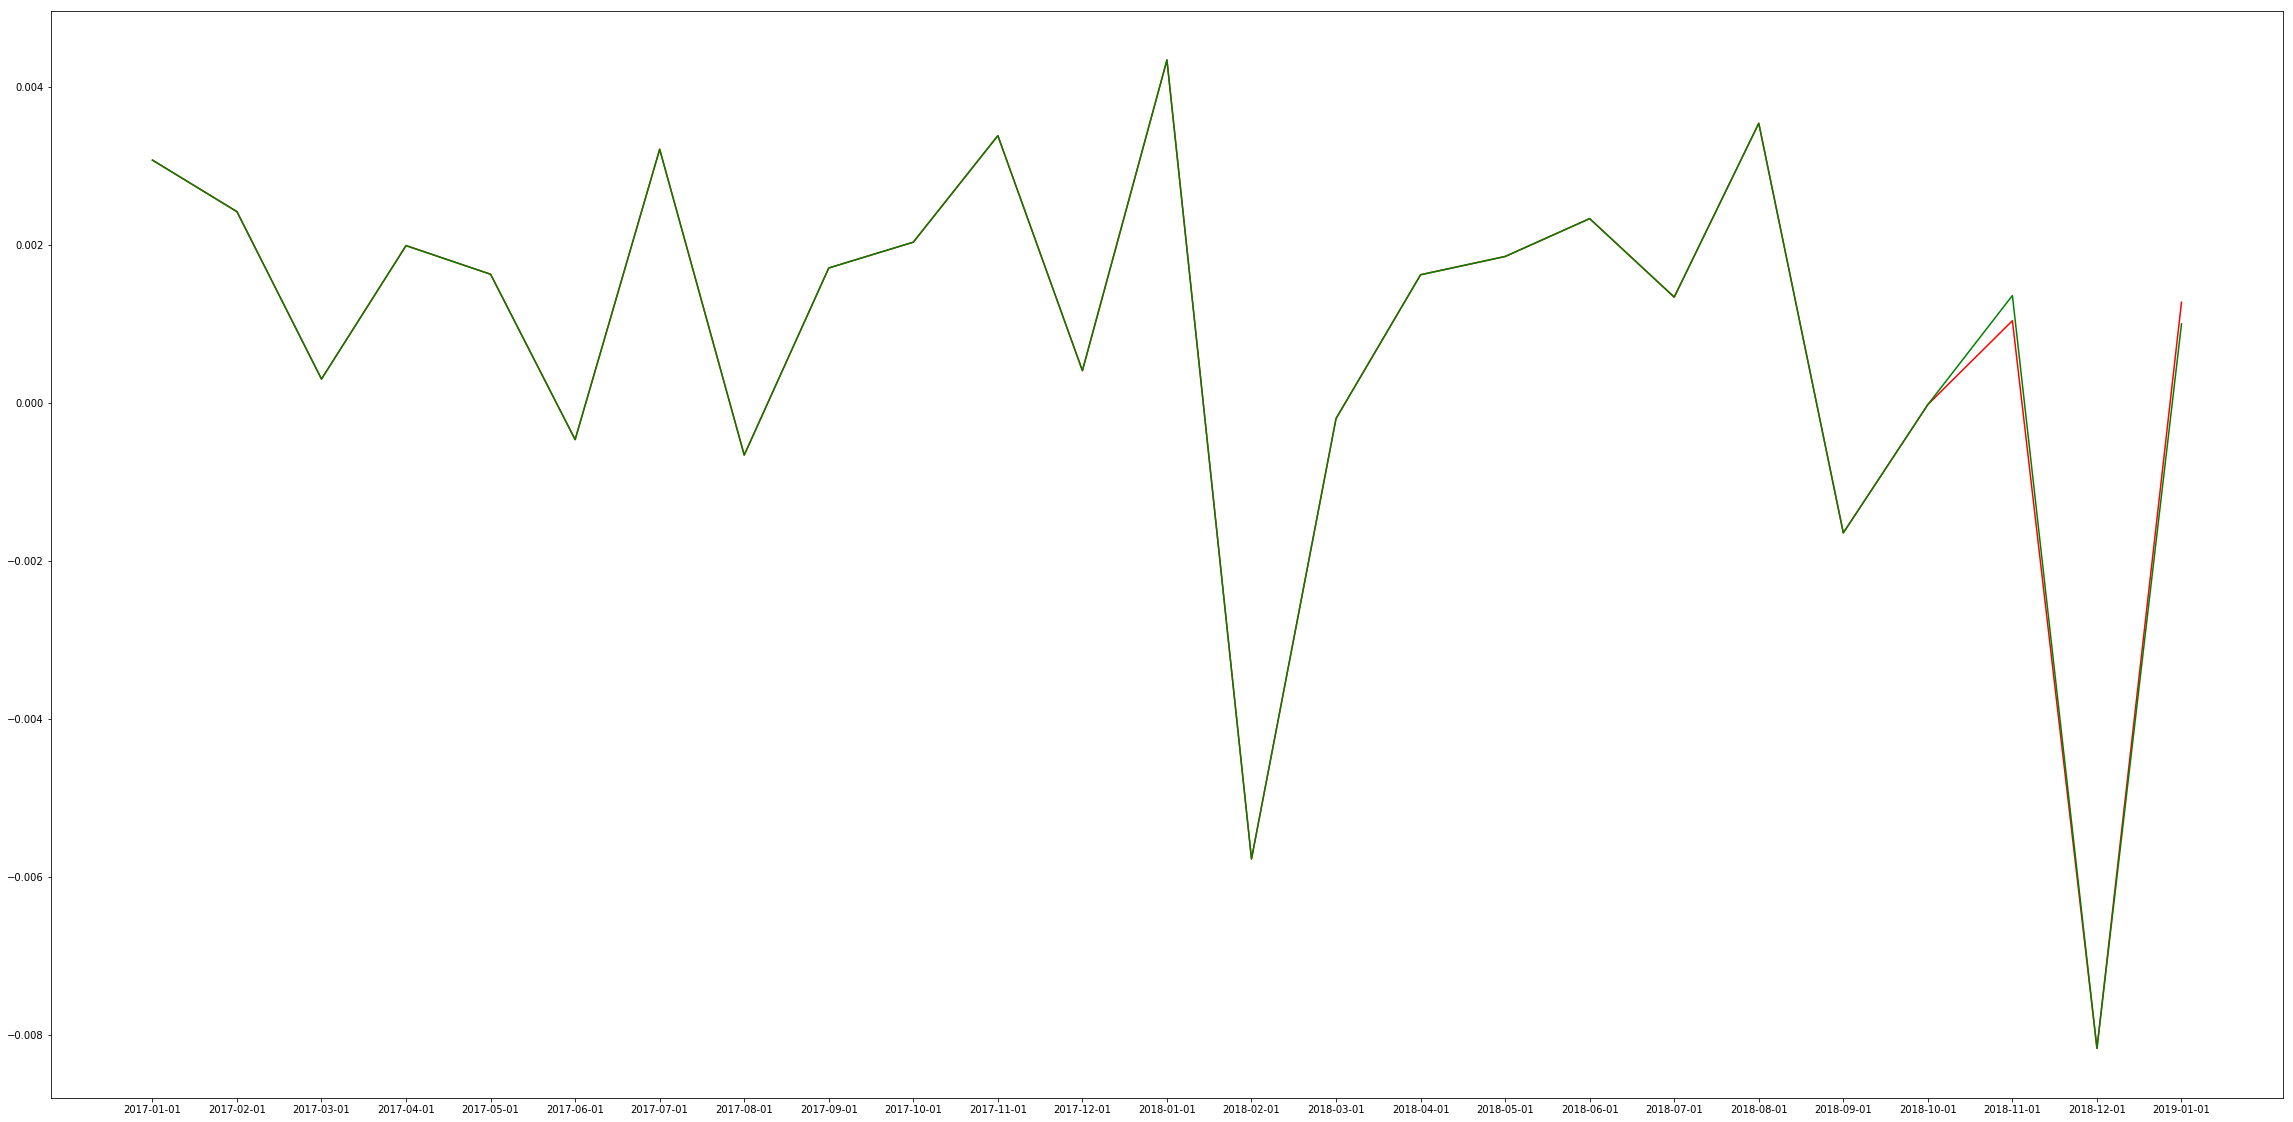

In [259]:
plt.figure(figsize=(40,20))
plt.plot(test,'r')
plt.plot(test01,'g')

In [243]:
print(test.mean(),test01.mean())

0    0.001064
dtype: float64 0    0.000829
dtype: float64
